In [192]:
import typing
import numpy as np
import cv2 as cv
import os, json
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<IPython.core.display.Javascript object>

In [193]:
RUN_EXAMPLES = True


class StopExecution(Exception):
    def _render_traceback_(self):
        pass


class Example:
    def __init__(self) -> None:
        if not RUN_EXAMPLES:
            raise StopExecution

<IPython.core.display.Javascript object>

## ProcessImageConfig

to process the image, we use an **ProcessImageConfig**, which contains information about what the 4 colors are in the image approximately:
- cell_color: e.g. black
- background_color: e.g. purple
- marker1_color: e.g. red
- marker2_color: e.g. green

Alternatively these can be obtained by performing clustering, maybe meanshift?

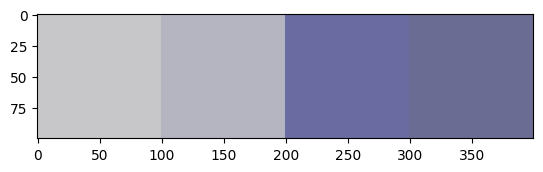

<IPython.core.display.Javascript object>

In [212]:
Color = Tuple[float, float, float]
# as hsv


@dataclass
class ProcessImageConfig:
    """all values in HSL integers"""

    background_color: Color
    cell_color: Color
    marker1_color: Color
    marker2_color: Color

    def show(self):
        im = np.zeros((100, 400, 3), np.float32)

        im[:, :100, :] = self.background_color
        im[:, 100:200, :] = self.cell_color
        im[:, 200:300, :] = self.marker1_color
        im[:, 300:, :] = self.marker2_color

        im = im / 255.0
        im = cv.cvtColor(im, cv.COLOR_HSV2BGR) * 2.55

        # # i[:, :10, :] = [1.0, 0, 0]

        # # print(i[50, 150, :] * 255.0)
        plt.imshow(im)
        plt.show()


def infer_config_from_image(image: cv.Mat) -> ProcessImageConfig:
    raise "not implemented"  # type: ignore


DISH1_CONFIG = ProcessImageConfig(
    background_color=(111, 3, 79),
    cell_color=(211, 17, 76),
    marker1_color=(289, 86, 63),
    marker2_color=(265, 69, 58),
)
DISH1_CONFIG.show()

## Preprocessing
(encompasses all things that do not need any ProcessImageConfig values)

1. blurring the image to get rid of noise

In [195]:
def preprocess_image(image: cv.Mat) -> cv.Mat:
    """assumes image to be BGR and will result HSV"""
    result = cv.blur(image, (5, 5))
    result = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    return result

<IPython.core.display.Javascript object>

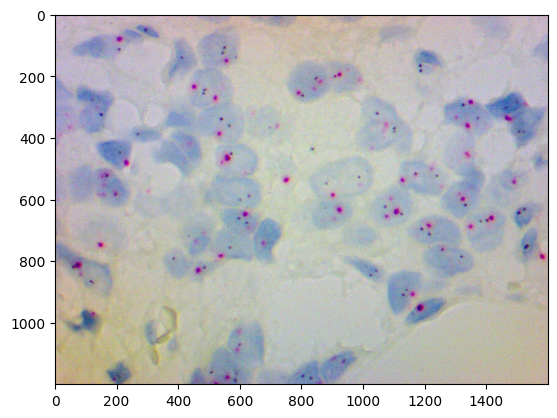

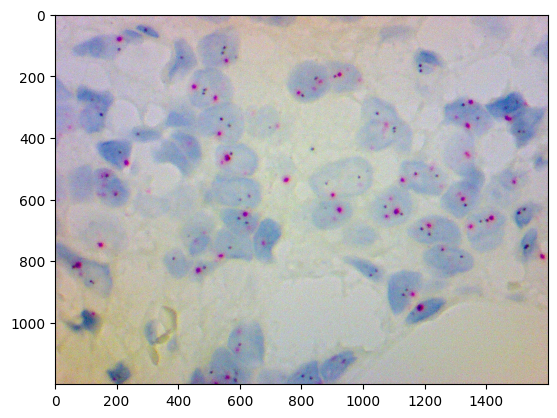

<IPython.core.display.Javascript object>

In [196]:
Example()

img = cv.imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
processed = preprocess_image(img)
# print(processed)

plt.imshow(cv.cvtColor(processed, cv.COLOR_HSV2RGB))
plt.show()

## Finding the cell/background separation

The next step is to make a distinction between cells and background.

For this we can calculate the distance from every pixels color to cell color vs. background color. The closest distance decides if this is black in the mask (background) or white (cells)

In [207]:
from math import sin, cos, pi
from numba import jit, njit


@njit(inline="always")
def hsvdist(h1: float, s1: float, v1: float, h2: float, s2: float, v2: float) -> float:
    # a = sin(h1) * s1 * v1 - sin(h2) * s2 * v2
    # a *= a
    # b = cos(h1) * s1 * v1 - cos(h2) * s2 * v2
    # b *= b
    # c = v1 - v2
    # c *= c
    # return a + b + c


@jit
def fore_ground_mask(img, config: ProcessImageConfig):
    """assumes image to be HLS"""
    output = img.copy()[:, :, 0]
    output[:, :] = 0
    height, width = img.shape[0], img.shape[1]

    pi2 = 2 * pi

    bg_h = float(config.background_color[0]) / 255.0 * pi2
    bg_s = float(config.background_color[1]) / 255.0
    bg_v = float(config.background_color[2]) / 255.0

    cell_h = float(config.cell_color[0]) / 255.0 * pi2
    cell_s = float(config.cell_color[1]) / 255.0
    cell_v = float(config.cell_color[2]) / 255.0

    m1_h = float(config.marker1_color[0]) / 255.0 * pi2
    m1_s = float(config.marker1_color[1]) / 255.0
    m1_v = float(config.marker1_color[2]) / 255.0

    m2_h = float(config.marker2_color[0]) / 255.0 * pi2
    m2_s = float(config.marker2_color[1]) / 255.0
    m2_v = float(config.marker2_color[2]) / 255.0

    for i in range(height):
        for j in range(width):

            h = float(img[i, j, 0]) / 255.0 * pi2
            s = float(img[i, j, 1]) / 255.0
            v = float(img[i, j, 2]) / 255.0

            m1_dist: float = hsvdist(h, s, v, m1_h, m1_s, m1_v)
            m2_dist: float = hsvdist(h, s, v, m2_h, m2_s, m2_v)
            cell_dist: float = hsvdist(h, s, v, cell_h, cell_s, cell_v)

            cell_dist: float = min(m1_dist, m2_dist, cell_dist)

            bg_dist: float = hsvdist(h, s, v, bg_h, bg_s, bg_v)
            # print(cell_dist, bg_dist)
            r: int = 255 if bg_dist > cell_dist else 0
            output[i, j] = r
    return output

<IPython.core.display.Javascript object>

[[[149  30 194]
  [151  33 202]
  [153  41 216]
  ...
  [155  16 190]
  [162  26 195]
  [162  30 189]]

 [[151  33 198]
  [154  38 202]
  [157  45 204]
  ...
  [156  21 190]
  [159  28 188]
  [159  30 194]]

 [[158  43 204]
  [158  45 205]
  [160  47 207]
  ...
  [151  30 187]
  [153  27 199]
  [156  27 199]]

 ...

 [[ 20  64 200]
  [ 18  63 211]
  [ 13  71 205]
  ...
  [ 11  60 200]
  [  8  54 203]
  [  6  50 213]]

 [[ 15  62 199]
  [ 13  57 223]
  [ 11  70 214]
  ...
  [  8  59 199]
  [  3  56 204]
  [179  54 206]]

 [[ 11  69 174]
  [ 11  66 201]
  [ 10  76 205]
  ...
  [  6  62 192]
  [  0  57 206]
  [177  61 213]]]


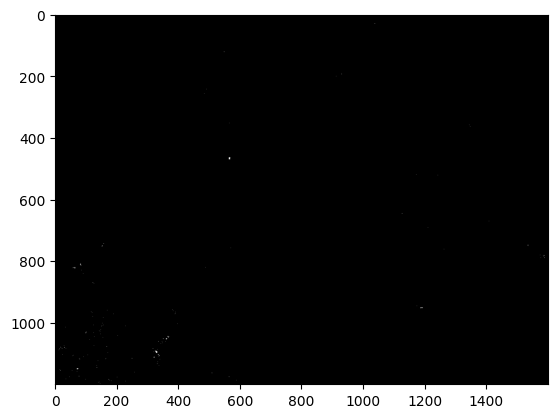

<IPython.core.display.Javascript object>

In [213]:
Example()

img = cv.imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
config = DISH1_CONFIG
img = preprocess_image(img)
print(img)
mask = fore_ground_mask(img, config)
plt.imshow(cv.cvtColor(mask, cv.COLOR_GRAY2RGB))

In [210]:
%%time

mask = fore_ground_mask(img, config)

CPU times: total: 46.9 ms
Wall time: 52 ms


<IPython.core.display.Javascript object>

In [216]:
img = cv.imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")


cv.equalizeHist(img)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'cv::equalizeHist'


<IPython.core.display.Javascript object>